In [ ]:
%pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.1 MB/s eta 0:00:00


In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # supress rdkit warnings
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI-based planning of organic synthesis [data]/reactions_datasets/dataset_smiles_descriptors.tsv', sep="\t")

<ipython-input-4-909493e922c6>:1: DtypeWarning: Columns (5,6,10,11,12,24,31,34,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/AI-based planning of organic synthesis [data]/reactions_datasets/dataset_smiles_descriptors.tsv', sep="\t")


In [ ]:
def get_fingerprint(x, nBits):
    fp_array = np.zeros((0,), dtype=np.int8)
    if x is not None and type(x) != float:
        mol = Chem.MolFromSmiles(x)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits) 
        ConvertToNumpyArray(fp, fp_array)
        return fp_array
    else:
        return np.zeros((nBits,), dtype=np.int8)

In [ ]:
def get_yield_class(y):
  if y <= 33:
    c = 0 #low
  elif y >= 34 and y <= 66:
    c = 1 #medium
  elif y >= 67:
    c = 2 #high
  return c

In [ ]:
df_new = pd.DataFrame()

In [ ]:
df_new['yield_value'] = df['yield_value'].apply(get_yield_class).to_frame().set_index(df.index)

In [ ]:
df_new['product'] = df['products_smiles'].apply(get_fingerprint, nBits=512).to_frame().set_index(df.index)

In [ ]:
df_new['reactants_I'] = df['reactants_smiles'].apply(get_fingerprint, nBits=128).to_frame().set_index(df.index)

In [ ]:
df_new['reactants_II'] = df['reactants_II_smiles'].apply(get_fingerprint, nBits=128).to_frame().set_index(df.index)

In [ ]:
df_new['reaction'] = df_new[['reactants_I', 'reactants_II', 'product']].apply(np.concatenate, axis=1)
reactions_fp = pd.DataFrame(df_new.loc[:, 'reaction'].values.tolist())

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(reactions_fp, df_new['yield_value'], test_size=0.25, random_state=42, shuffle=True)

In [ ]:
model = xgb.XGBClassifier(random_state=1)
model.fit(X_train_3, y_train_3)

In [ ]:
y_test_pred = model.predict(X_test_3)

In [ ]:
print('Accuracy:', accuracy_score(y_test_3, y_test_pred))
print('Precision:', precision_score(y_test_3, y_test_pred, average='weighted'))
print('Recall:', recall_score(y_test_3, y_test_pred, average='weighted'))
print('F1-score:', f1_score(y_test_3, y_test_pred, average='weighted'))

Accuracy: 0.7481549476776207
Precision: 0.7090370388442009
Recall: 0.7481549476776207
F1-score: 0.6778053458000308


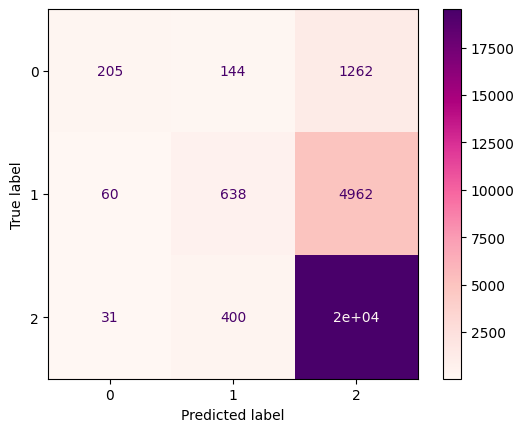

In [ ]:
cm = confusion_matrix(y_test_3, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.RdPu)
cm_display

In [ ]:
y_train_pred = model.predict(X_train_3)

In [ ]:
print('Accuracy:', accuracy_score(y_train_3, y_train_pred))
print('Precision:', precision_score(y_train_3, y_train_pred, average='weighted'))
print('Recall:', recall_score(y_train_3, y_train_pred, average='weighted'))
print('F1-score:', f1_score(y_train_3, y_train_pred, average='weighted'))

Accuracy: 0.8005434383491224
Precision: 0.8256744130022092
Recall: 0.8005434383491224
F1-score: 0.7562186049613491


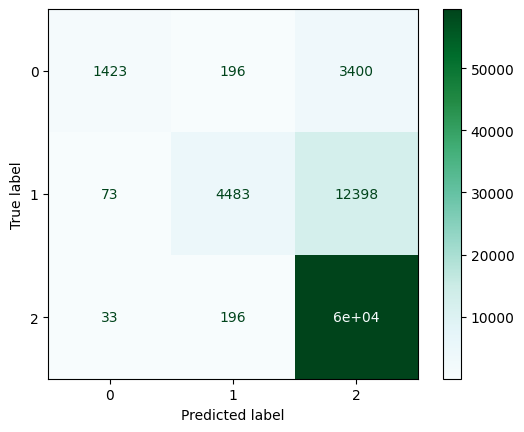

In [ ]:
cm = confusion_matrix(y_train_3, y_train_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.BuGn)
cm_display